# Exercise: Complete Modeling Workflow (With Answers)

**Download: ``http://shorturl.at/crOS2/Lecture_12``**

File obsdata.csv contains four columns, each with 20 points. The columns are: time, A, B, C. 
1. Evaluate each of the following models using cross validation to find which provides the best fit.

    Model 1:

        A -> B

        B -> C


    Model 2:

         A -> B

         A -> C

    Model 3:

         A + B -> C

    All kinetics are mass action. A is starts at 5M, and all other concentrations are 0.
    Kinetics constants are in [0, 10]
    
    a. Write the full Antimony models for each of the above.
    
    b. What simulation time should you use? How many points?
    
    c. Do cross validation on each. Which has the largest $R^2$ across folds?
    
    d. Did some folds in cross validation produce much better fits than others? Why?

2. Construct a 95% confidence interval for the model with the best fit.

3. The "observational data" were generated by a model that contains a chemical species D that is not present in the other models. How might we detect that there is a missing chemical species?

Hint: You can read data in a CSV file into a numpy array using ``np.genfromtxt("obsdata.csv", delimiter=",", skip_header=True)``.

## Checkpoints
1. Antimony models. Insert kinetics and constant initializations.
1. Plot observational data, identifying time periods over which fitting is done.
1. Cross validation results
   1. Model 1
   1. Model 2
   1. Model 3
1. Choice for "best model"
1. Parameter estimates and evaluation.

In [1]:
%matplotlib inline
import numpy as np
import model_fitting as mf

In [2]:
# Globals
num_points = 10
sim_time = 30

## Full model

In [3]:
# Model used in this example
model0 = """
     # True model
     A  -> B; k1*A
     A + B -> D; k2*A*B
     D -> C; k3*D
      
     A = 5;
     B = 0;
     C = 0;
     D = 0;
     k1 = 0.5
     k2 = 0.2
     k3 = 0.1
"""
unfitted_parameters = mf.makeParameters(constants=['k1', 'k2', 'k3'])
unfitted_parameters

name,value,initial value,min,max,vary
k1,1.00000000,1,0.00000000,10.0000000,True
k2,1.00000000,1,0.00000000,10.0000000,True
k3,1.00000000,1,0.00000000,10.0000000,True


In [4]:
noise_std = 0.2
full_obs_data = mf.makeObservations(model=model0, noise_std=noise_std, num_points=num_points, sim_time=sim_time)
obs_data = full_obs_data[:, [0, 1, 2,  4]]
obs_data

 [[       0,    5.30338,       0,         0],
  [ 3.33333,   0.624419, 1.96568, 0.0161994],
  [ 6.66667, 0.00986332, 2.44345,  0.647043],
  [      10,  0.0668274, 1.94701,   1.22008],
  [ 13.3333,          0, 1.64753,   1.16427],
  [ 16.6667,   0.278231, 1.83542,    1.6209],
  [      20,   0.307103, 1.47444,   1.54326],
  [ 23.3333,          0, 1.78815,   1.29012],
  [ 26.6667,          0, 1.62093,   1.57282],
  [      30,          0, 2.18099,   1.13567]]

In [5]:
def writeCSV(data, filename="obsdata.csv"):
    import pandas as pd
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
writeCSV(obs_data)

In [6]:
obs_data = np.genfromtxt("obsdata.csv", delimiter=",", skip_header=True)
obs_data

array([[0.00000000e+00, 5.30338114e+00, 0.00000000e+00, 0.00000000e+00],
       [3.33333333e+00, 6.24419220e-01, 1.96568013e+00, 1.61994072e-02],
       [6.66666667e+00, 9.86331524e-03, 2.44345431e+00, 6.47042951e-01],
       [1.00000000e+01, 6.68273821e-02, 1.94701391e+00, 1.22007734e+00],
       [1.33333333e+01, 0.00000000e+00, 1.64753006e+00, 1.16427214e+00],
       [1.66666667e+01, 2.78231160e-01, 1.83541742e+00, 1.62090066e+00],
       [2.00000000e+01, 3.07102992e-01, 1.47443899e+00, 1.54325910e+00],
       [2.33333333e+01, 0.00000000e+00, 1.78815432e+00, 1.29011680e+00],
       [2.66666667e+01, 0.00000000e+00, 1.62092831e+00, 1.57282088e+00],
       [3.00000000e+01, 0.00000000e+00, 2.18099400e+00, 1.13566598e+00]])

In [7]:
full_obs_data

       time,        [A],     [B],      [D],       [C]
 [[       0,    5.30338,       0,        0,         0],
  [ 3.33333,   0.624419, 1.96568,  1.29876, 0.0161994],
  [ 6.66667, 0.00986332, 2.44345, 0.886335,  0.647043],
  [      10,  0.0668274, 1.94701, 0.781159,   1.22008],
  [ 13.3333,          0, 1.64753, 0.434442,   1.16427],
  [ 16.6667,   0.278231, 1.83542,  0.26374,    1.6209],
  [      20,   0.307103, 1.47444, 0.417886,   1.54326],
  [ 23.3333,          0, 1.78815,  0.18047,   1.29012],
  [ 26.6667,          0, 1.62093, 0.126734,   1.57282],
  [      30,          0, 2.18099,        0,   1.13567]]

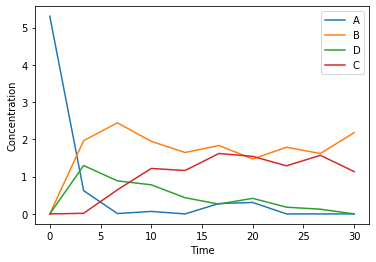

In [8]:
mf.plotTimeSeries(full_obs_data, columns=['A', 'B', 'D', 'C'])

## Candidate models

In [9]:
models = []
parameters_list = []
# Model used in this example
model = """
    # Model 1
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
     k2 = 0
"""
parameters_list.append(mf.makeParameters(constants=['k1', 'k2']))
models.append(model)

model = """
     # Model 2
     A -> B; k1*A
     A -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
     k2 = 0
"""
parameters_list.append(mf.makeParameters(constants=['k1', 'k2']))
models.append(model)


model = """
     # Model 3
     A + B -> C; k1*A
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
"""
parameters_list.append(mf.makeParameters(constants=['k1']))
models.append(model)

In [10]:
for model in models:
    print(model)


    # Model 1
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
     k2 = 0


     # Model 2
     A -> B; k1*A
     A -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
     k2 = 0


     # Model 3
     A + B -> C; k1*A
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0



## Model Analysis

In [19]:
# Evaluation using cross validation
frac = 0.6
for model, parameters in zip(models, parameters_list):
    print("\nModel: %s" % model)
    idx = int(frac*num_points)
    _, rsqs = mf.crossValidate(obs_data[0:idx], model=model, parameters=parameters, 
                                         num_points=idx, 
                                         method='leastsq',
                                         sim_time=sim_time*0.8,
                                         num_folds=3)
    print(rsqs)


Model: 
    # Model 1
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
     k2 = 0

[0.9050349437274813, -0.670954194611963, 0.7836187382183433]

Model: 
     # Model 2
     A -> B; k1*A
     A -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0
     k2 = 0

[0.1618996354774518, -0.8182268028776796, -7.149323572180609]

Model: 
     # Model 3
     A + B -> C; k1*A
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0

[-0.1468640505673373, -11.438161653444906, -9.62776526211155]


In [12]:
list_parameters, rsqs = mf.crossValidate(full_obs_data, model=model0, parameters=unfitted_parameters, 
                                         num_points=num_points, method='leastsq',
                                         sim_time=sim_time,
                                         num_folds=3)
rsqs

[0.9751350642530657, 0.885147023109397, 0.9254649112325273]

In [13]:
mf.doBootstrap(full_obs_data, model=model0, parameters=unfitted_parameters, 
                                         num_points=num_points, method='leastsq',
                                         sim_time=sim_time, count=5)

{'k1': array([1.29958106, 8.9137695 ]),
 'k2': array([0.55887884, 3.26683653]),
 'k3': array([0.10997284, 0.340464  ])}

In [20]:
mf.doBootstrap(obs_data, model=models[0], parameters=parameters_list[0], 
                                         num_points=num_points,
                                         sim_time=sim_time, count=5)

{'k1': array([0.15561329, 0.38623491]), 'k2': array([0.03823694, 0.05427839])}